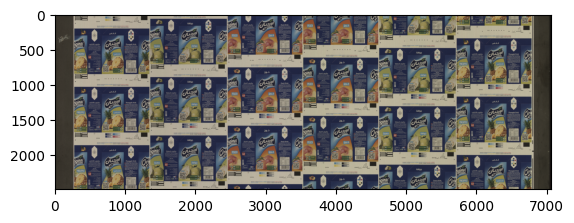

In [136]:
import cv2
from matplotlib import pyplot as plt

path = '/Users/omarelherraoui/Documents/pioneers4.0/PioneersHackathon4.0/data/Job1.bmp'
im = cv2.imread(path)
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im_rgb)
plt.show()

In [71]:
import fitz
import os
 
def pdf_to_jpg(pdf_path, output_folder, zoom_x=2.0, zoom_y=2.0):
    pdf_document = fitz.open(pdf_path)
 
    # Create a zoom matrix to increase resolution
    mat = fitz.Matrix(zoom_x, zoom_y)
 
    for page_number in range(pdf_document.page_count):
        page = pdf_document[page_number]
        image = page.get_pixmap(matrix=mat)  # apply the zoom matrix
 
        jpg_filename = os.path.join(output_folder, f'page_{page_number + 3}.jpg')
        image.save(jpg_filename)
 
    pdf_document.close()

# Usage example
pdf_path = '/Users/omarelherraoui/Documents/pioneers4.0/PioneersHackathon4.0/samples/SA-A073.pdf'  # Replace 'input.pdf' with the path to your PDF file
output_folder = '/Users/omarelherraoui/Documents/pioneers4.0/PioneersHackathon4.0/samples_images'  # Output folder where JPG images will be saved
os.makedirs(output_folder, exist_ok=True)

pdf_to_jpg(pdf_path, output_folder)


ModuleNotFoundError: No module named 'PyMuPDF'

In [83]:
def decode_predictions(scores, geometry):
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        for x in range(0, numCols):
            if scoresData[x] < 0.5:
                continue

            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    return (rects, confidences)

def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
    if len(boxes) == 0:
        return []

    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    pick = []

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(probs)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    return boxes[pick].astype("int")


$2746 SA-A073-45-B0053
0097 SA-A073-85-P2756


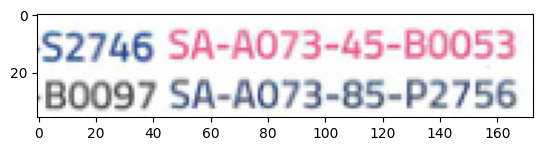

In [129]:
import cv2
import numpy as np

# Load the pre-trained EAST model
net = cv2.dnn.readNet('frozen_east_text_detection.pb')

# Load the image
image = cv2.imread('/Users/omarelherraoui/Documents/pioneers4.0/PioneersHackathon4.0/samples_images/page_2.jpg')
image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
orig = image.copy()
(h, w) = image.shape[:2]

# Set the new width and height and determine the ratio in change for both
(newW, newH) = (320, 320)
rW = w / float(newW)
rH = h / float(newH)

# Resize the image and grab the new image dimensions
image = cv2.resize(image, (newW, newH))
(h, w) = image.shape[:2]

# Define the two output layer names for the EAST detector model
layerNames = [
    "feature_fusion/Conv_7/Sigmoid",
    "feature_fusion/concat_3"]

# Convert the image to a blob and perform forward pass to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(image, 1.0, (w, h), (123.68, 116.78, 103.94), swapRB=True, crop=False)
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)

# Decode the predictions
(rects, confidences) = decode_predictions(scores, geometry)
boxes = non_max_suppression(np.array(rects), probs=confidences)

# Extract the top-most bounding box
if len(boxes) > 0:
    boxes = sorted(boxes, key=lambda r:r[1])
    top_box = boxes[1]
    startX, startY, endX, endY = top_box
    roi = orig[int(startY*rH):int(endY*rH), int(startX*rW):int(endX*rW)]
    extracted_id = pytesseract.image_to_string(roi, config='--psm 6').strip()
    print(extracted_id)
    plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    plt.show()


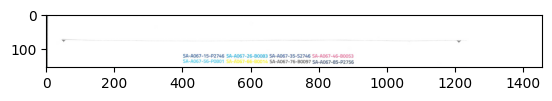

¥ ¥
SA-AO67-15-P2746 SA-A067-26-B0083 SA-A067-35-S2746 SA-A067~46-B0053
SA-A067-56-POBO1 SA~A067-66-B0014 SA-AO67-76-B0097 SA-AQ67-85-P2756


In [84]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

# Load the image
image = cv2.imread('/Users/omarelherraoui/Documents/pioneers4.0/PioneersHackathon4.0/samples_images/page_1.jpg')

import cv2
import pytesseract

# Convert to appropriate format for processing
img_array = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

# Rotate the image to make it vertical
rotated_img = cv2.rotate(img_array, cv2.ROTATE_90_COUNTERCLOCKWISE)

# Extract the top portion for ID detection
# top_portion = rotated_img[:160]
# Define a percentage of the image height for potential ID extraction
percentage = 0.15 # This means 5% of the image height

# Calculate the height slice based on the percentage
height_slice = int(rotated_img.shape[0] * percentage)

# Extract the adaptive top portion
adaptive_top_portion = rotated_img[:height_slice]

# Display the extracted portion
plt.imshow(adaptive_top_portion)
plt.show()
# Use OCR to extract the ID
extracted_id = pytesseract.image_to_string(adaptive_top_portion, config='--psm 6').strip()
print(extracted_id)
